# covid-19 World

## Goals
### A. Daily New Corona Cases Forecast
### B. Daily Deaths Prediction

The forecaste of New corona cases worldwide will help in determining the magnitude of the coronavirus pandemic in coming days. Which will help the world goverments to embrace for the future challenges and prepare for it in order to make forecast fail. 

Daily death prediction will also help the world goverments to judge their health care system and the arrangements made to cure corovirus effected people. This will lead the health care system to optimize better for future cases.  

## Import Dataset and Libraries.  
##### source= [WHO](https://covid19.who.int/?gclid=EAIaIQobChMI2pGr-7rY6QIVgdeWCh2YPwsFEAAYASAAEgImqPD_BwE)
In this section I would import the libraries and dataset to be used in this project

In [1]:
#general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#to build forecast
from datetime import datetime
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

#to build the model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split


#to evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tools.eval_measures import rmse



In [277]:
covid_world = pd.read_csv('covid_D.csv',header=0,index_col = 'Date', parse_dates=True,squeeze=True)

In [77]:
#checking the index to make sure that dates are of datetime type
covid_world.index

DatetimeIndex(['2020-01-11', '2020-01-12', '2020-01-13', '2020-01-14',
               '2020-01-15', '2020-01-16', '2020-01-17', '2020-01-18',
               '2020-01-19', '2020-01-20',
               ...
               '2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04',
               '2020-06-05', '2020-06-06', '2020-06-07', '2020-06-08',
               '2020-06-09', '2020-06-10'],
              dtype='datetime64[ns]', name='Date', length=152, freq=None)

In [78]:
#need to change the frequency(freq) from none to daily(d)
covid_world.index.freq = 'D'
covid_world.index

DatetimeIndex(['2020-01-11', '2020-01-12', '2020-01-13', '2020-01-14',
               '2020-01-15', '2020-01-16', '2020-01-17', '2020-01-18',
               '2020-01-19', '2020-01-20',
               ...
               '2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04',
               '2020-06-05', '2020-06-06', '2020-06-07', '2020-06-08',
               '2020-06-09', '2020-06-10'],
              dtype='datetime64[ns]', name='Date', length=152, freq='D')

##### Lets check the head of the data

In [79]:
covid_world.head()

,New Cases,Total Cases,New Deaths,Total Cases.1
Date,,,,
2020-01-11,41,1,1,41
2020-01-12,0,1,0,41
2020-01-13,1,1,0,42
2020-01-14,1,1,0,43
2020-01-15,0,1,0,43


## Data Visualization

##### Date wise corona daily cases and daily deaths worldwide

<Figure size 432x288 with 0 Axes>

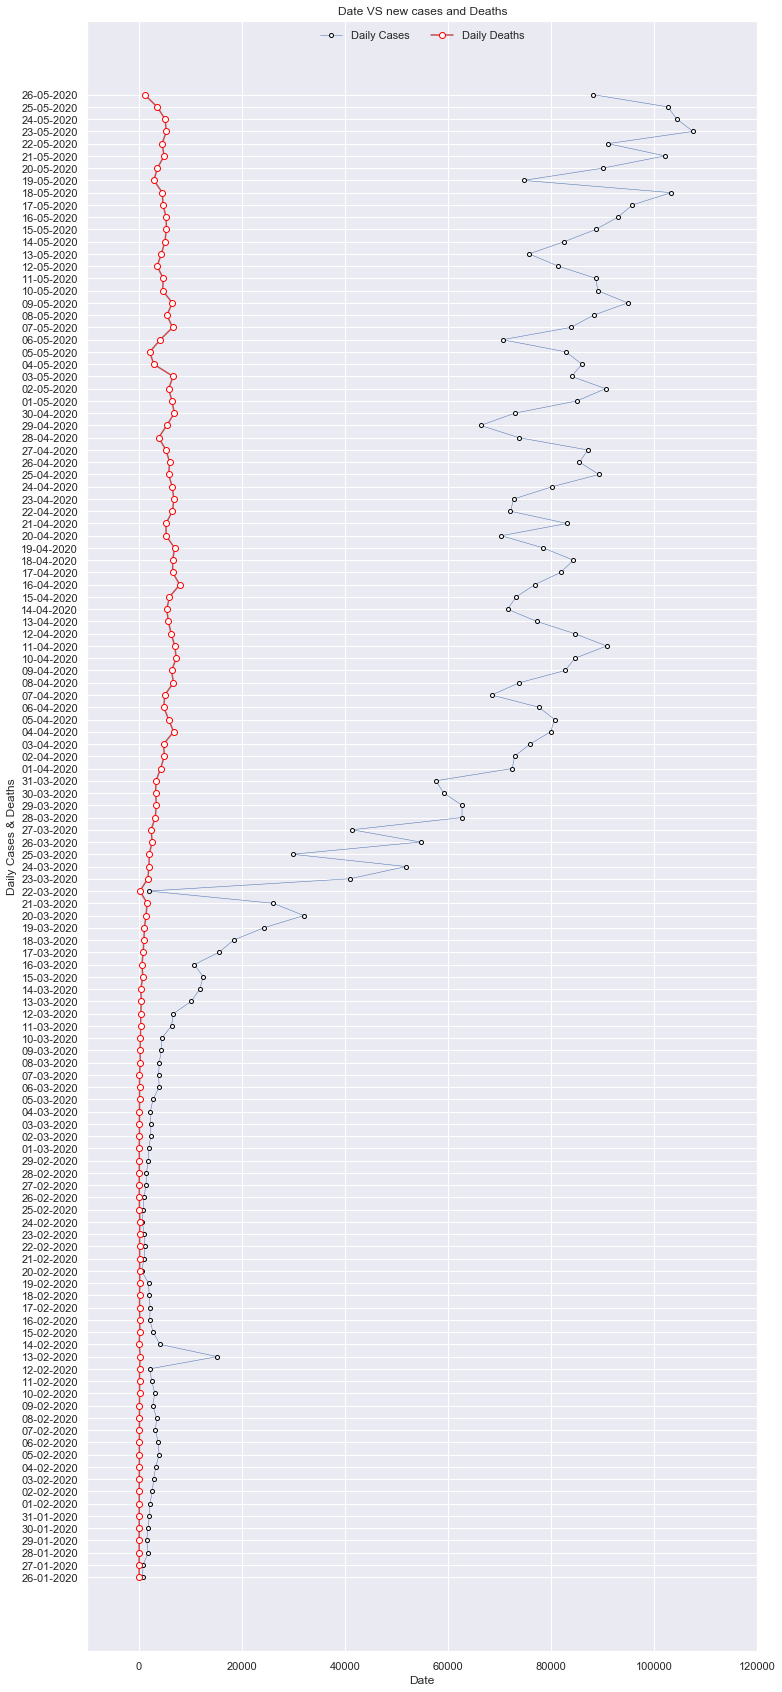

In [365]:
covid = pd.read_csv('covid_D.csv')
fig = plt.figure()
plt.figure(figsize=(12,30))
ax=plt.axes()
plt.plot(covid['New Cases'][15:137], covid['Date'][15:137],'-ob',label='Daily Cases',markersize=4, linewidth=0.5,markerfacecolor='white',markeredgecolor='black');
plt.plot(covid['New Deaths'][15:137], covid['Date'][15:137],'-or',label='Daily Deaths',markerfacecolor='white',markeredgecolor='red');
plt.xlim(-10000,120000)
plt.title('Date VS new cases and Deaths')
plt.xlabel('Date')
plt.ylabel("Daily Cases & Deaths")
plt.legend()
ax.legend(frameon=False, loc='upper center', ncol=2)
sns.set()
#plt.axis('equal')

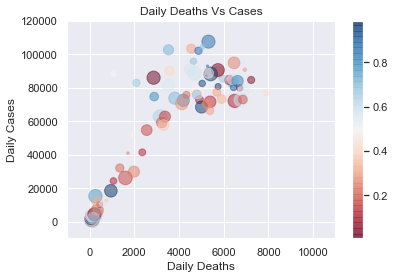

In [366]:
rng = np.random.RandomState(0)
x = covid['New Deaths'][15:137]
y = covid['New Cases'][15:137]
plt.xlabel('Daily Deaths')
plt.ylabel('Daily Cases')
colors = rng.rand(122)
sizes = 200 * rng.rand(1000)
plt.scatter(x, y, c=colors, s=sizes, alpha=0.5,cmap='RdBu')
plt.title('Daily Deaths Vs Cases')
plt.colorbar();
plt.xlim(-1000,11000)
plt.ylim(-10000,120000)
sns.set()

## A. Daily New Corona Cases Forecast

In [80]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

### Checking the time series is stationary or non-stationary
To determine if an incoming time series is stationary, let's write a function that performs the augmented Dickey-Fuller Test.

In [81]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [82]:
adf_test(covid_world['New Cases'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.619469
p-value                   0.866522
# lags used              13.000000
# observations          138.000000
critical value (1%)      -3.478648
critical value (5%)      -2.882722
critical value (10%)     -2.578065
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


As the data is **non-stationary**, which is confirmed by the above Augmented Dicky Fuller test, we will have to introducte **Differencing** which will make the data stationary for forecast. 

In [83]:
from statsmodels.tsa.statespace.tools import diff
covid_world['diff-1'] = diff(covid_world['New Cases'],k_diff=2)
adf_test(covid_world['diff-1'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.105249e+01
p-value                 5.039275e-20
# lags used             8.000000e+00
# observations          1.410000e+02
critical value (1%)    -3.477601e+00
critical value (5%)    -2.882266e+00
critical value (10%)   -2.577822e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


So by **differencing at 2** we get the data **stationary**.

### Checking the seasonality of the time series by Seasonal Decompose method

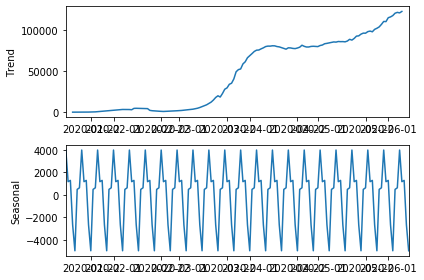

In [84]:
SD = seasonal_decompose(covid_world['New Cases'], model = 'add')
SD.plot(observed=False,seasonal=True,trend=True,resid=False);

So there is a seasonality componant in the data. As the data is daily we will take **m=7**

##### As the data has seasonality we will use SARIMA to get the forecast

### Getting parameters p,d,q and P,D,Q for SARIMA MODEL
We will use auto_arima function from pmdarima library to get the parameters and later we will confirm p and q by using acf and pacf plots

In [85]:
auto_arima(covid_world['New Cases'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  152
Model:             SARIMAX(0, 1, 1)x(0, 0, [1, 2], 7)   Log Likelihood               -1563.590
Date:                                Thu, 11 Jun 2020   AIC                           3137.180
Time:                                        15:01:29   BIC                           3152.266
Sample:                                             0   HQIC                          3143.309
                                                - 152                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1212.8609    431.414      2.811      0.005     367.305    2058.417
ma.L1         -0.6397      0.065     -9.899      0.000      -0.766      -0.513
ma.S.L7        0.2937      0.090      3.281      0.001       0.118       0.469
ma.S.L14       0.2281      0.114      2.004      0.045       0.005       0.451
sigma2      6.868e+07      0.002   3.78e+10      0.000    6.87e+07    6.87e+07
===================================================================================
Ljung-Box (Q):                       71.23   Jarque-Bera (JB):                36.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.16   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.57e+27. Standard errors may be unstable.
"""

By running the auto_arima function we got the following **parameters**:
* **Order** = (0, 1, 1)
* **Seasonal_Order** = (0, 0, [1, 2], 7)

Lets Now confirm p and q component values through acf and pacf plots

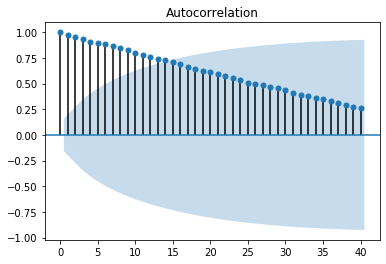

In [86]:
plot_acf(covid_world['New Cases'],lags=40);

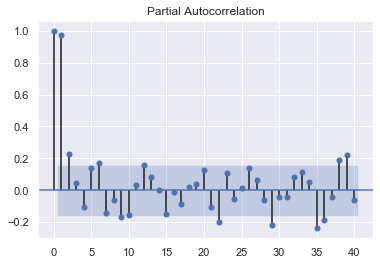

In [368]:
plot_pacf(covid_world['New Cases'],lags=40);

It is clear from the above models that the p value is 0 (pacf) and q value is 1 (acf)

## Spliting the data into train/test set
Steps:
* Split known data into a training set of records on which to fit the model
* Use the remaining records for testing, to evaluate the model
* Fit the model again on the full set of records
* Predict a future set of values using the model

In [88]:
train = covid_world.iloc[:120]
test = covid_world.iloc[120:152]

In [89]:
model_test=SARIMAX(train['New Cases'],order = (0,1,1),seasonal_order=(0,0,[1,2],7))

In [90]:
fit_test=model_test.fit()

In [91]:
start = len(train)
end = len(train) + len(test) - 1

In [92]:
forecast_test = fit_test.predict(start = start, end = end, typ = 'levels').rename("forecast")

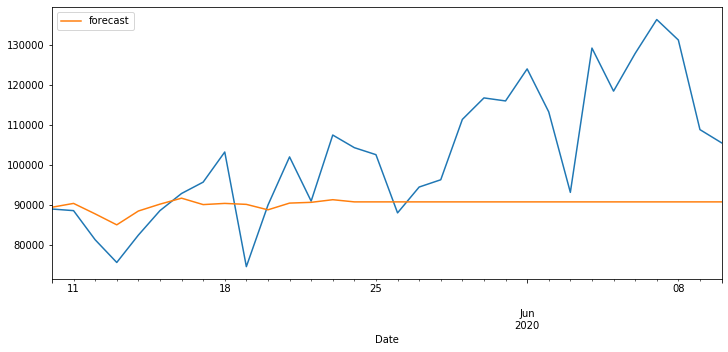

In [93]:
test['New Cases'].plot(figsize=(12,5))
forecast_test.plot(legend=True)

### Evaluate the Model
by Root mean square error


In [94]:
error = rmse(test['New Cases'], forecast_test)
print(f'ARIMA(0,1,1) RMSE Error: {error:11.10}')

ARIMA(0,1,1) RMSE Error: 19838.76675


In [95]:
test['New Cases'].mean()

102591.78125

So the RMSE value is in **1:5 ratio** with the mean, which is pretty good. Now lets forecast for the future dates.

## Forecasting
Now we're ready to train our best model on the greatest amount of data, and fit it to future dates.

In [96]:
model_final=SARIMAX(covid_world['New Cases'],order = (0,1,1),seasonal_order=(0,0,[1,2],7))

In [97]:
fit_final = model_final.fit()

In [98]:
forecast_final = fit_final.predict(start = len(covid_world), end = len(covid_world) +11, typ = 'levels').rename("Forecasted new cases till 22nd June")

Text(0, 0.5, 'New Cases')

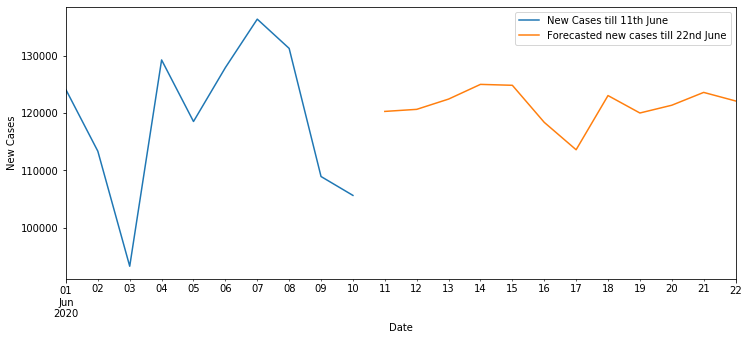

In [99]:
covid_world['New Cases'][142:152].plot(figsize=(12,5),legend=True, label = 'New Cases till 11th June')
forecast_final.plot(legend=True)
plt.ylabel('New Cases')

#### Date wise New Corona Cases in the world from 12th June to 22nd June

In [332]:
forecast_final.astype(int)

2020-06-11    120290
2020-06-12    120649
2020-06-13    122444
2020-06-14    125012
2020-06-15    124852
2020-06-16    118382
2020-06-17    113594
2020-06-18    123058
2020-06-19    120013
2020-06-20    121369
2020-06-21    123610
2020-06-22    122117
Freq: D, Name: Forecasted new cases till 22nd June, dtype: int32

In [334]:
covid_forecast = pd.DataFrame(forecast_final.astype(int).rename('New Cases'))

In [355]:
covid_forecast

,New Cases
2020-06-11,120290
2020-06-12,120649
2020-06-13,122444
2020-06-14,125012
2020-06-15,124852
2020-06-16,118382
2020-06-17,113594
2020-06-18,123058
2020-06-19,120013
2020-06-20,121369


In [354]:
covid_forecast.drop(['New Deaths'], axis = 1,inplace=True) 

# B. Daily Deaths prediction

Implementing linear regression to predict daily deaths

In [297]:
lr = LinearRegression()

### Spliting the data into train/test set
Steps:
* Split known data into a training set and test set on random basis using train test spilt
* Fit the model on training set and test it on test set.
* Predict a future set of values using the model

In [278]:
covid_world.columns

Index(['New Cases', 'Total Cases', 'New Deaths', 'Total Cases.1'], dtype='object')

In [320]:
X= covid_world[['New Cases']]
y= covid_world[['New Deaths']]

In [321]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=102)

In [322]:
model1=lr.fit(X_train,y_train)

In [323]:
y_lr=lr.predict(X_test)

In [324]:
rmse = np.sqrt(mean_squared_error(y_test,y_lr))
r2 = (r2_score(y_test,y_lr))
print(rmse)
print(r2)

1240.658413701904
0.7983872708626593


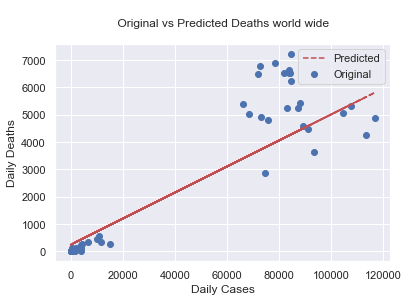

In [325]:
plt.scatter(X_test,y_test,label = "Original")
plt.plot(X_test,y_lr,'--r',label = "Predicted")
plt.legend()
plt.xlabel('Daily Cases')
plt.ylabel('Daily Deaths')
plt.title('\n Original vs Predicted Deaths world wide \n')
sns.set()

Implementing **ridge regression** to predict daily deaths

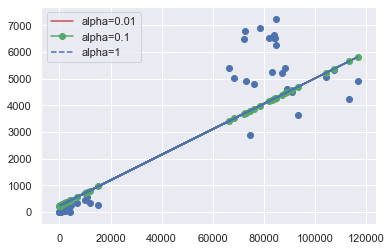

In [326]:
model_r1 = Ridge(alpha=0.01)
model_r1.fit(X_train,y_train)
model_r2= Ridge(alpha=0.1)
model_r2.fit(X_train,y_train)
model_r3= Ridge(alpha=1)
model_r3.fit(X_train,y_train)

#plotting all the models
plt.plot(X_test,model_r1.predict(X_test),'r',label='alpha=0.01')
plt.plot(X_test,model_r2.predict(X_test),'-og',label='alpha=0.1')   
plt.plot(X_test,model_r3.predict(X_test),'--b',label='alpha=1')   
plt.legend()
plt.scatter(X_test,y_test)

In [329]:
print("Train and Test set score")

for i in [model1,model_r1,model_r2,model_r3]:
    x= round(i.score(X_train,y_train)*100)
    y=round(i.score(X_test,y_test)*100)
    print(f"{i}={x}"" %")
    print(f"{i}={y}"" %\n")
    

Train and Test set score
LinearRegression()=74.0 %
LinearRegression()=80.0 %

Ridge(alpha=0.01)=74.0 %
Ridge(alpha=0.01)=80.0 %

Ridge(alpha=0.1)=74.0 %
Ridge(alpha=0.1)=80.0 %

Ridge(alpha=1)=74.0 %
Ridge(alpha=1)=80.0 %



As it is evident from the above socres that using linearregression or Ridge regression will give **similar results** so here I will prefer linear regression for building my model. 

In [356]:
covid_forecast['New Deaths'] =  lr.predict(covid_forecast).astype(int)

## Final Results for the next 12 Days

In [357]:
covid_forecast

,New Cases,New Deaths
2020-06-11,120290,5977
2020-06-12,120649,5994
2020-06-13,122444,6080
2020-06-14,125012,6202
2020-06-15,124852,6195
2020-06-16,118382,5886
2020-06-17,113594,5658
2020-06-18,123058,6109
2020-06-19,120013,5964
2020-06-20,121369,6029
